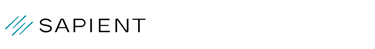

# Sapient Data Science Test Project

Kendall McNeil, January 2024

# A. Project Description

*Objective: The primary focus of this project is to determine whether an individual will develop diabetes over the course of the study (incident_diabetes = 1) or not (incident_diabetes = 0). The project aims to identify the blood biomarkers associated with the development of diabetes, constituting a binary classification problem.

- DISEASE FOCUS: In a public health study, participants were enrolled from communities for physical exams, blood tests, and were followed up for years with disease outcomes. We are interested in investigating blood biomarkers for a prevalent and detrimental disease – diabetes. 

- EXISTING/INCIDENT_DIABETES: A portion of the participants were already diagnosed to have diabetes at the time of enrollment (baseline). These participants have “existing_diabetes” outcome as 1. Some participants later on developed diabetes during the follow up period of the study. We call these new development of diabetes “incident_diabetes”. 

- DIABETES_TIME: For participants with incident diabetes, “diabetes_time” indicates the number of years it took to develop diabetes since baseline enrollment. For participants with existing diabetes, “diabetes_time” is negative and indicates the number of years the diagnosis of diabetes was made prior to baseline enrollment. For participants without diabetes at any time, “diabetes_time” indicates the number of years of follow up time since enrollment.

- DEMOGRAPHIC INFO: Demographic variables include age, sex, and body-mass-index (BMI).

- MTB: Blood biomarkers are denoted as “mtb_*”. When there is a missing value for blood biomarkers, it is usually due to the extremely low abundance of that biomarker in blood samples which could be below the lower limit of detection.

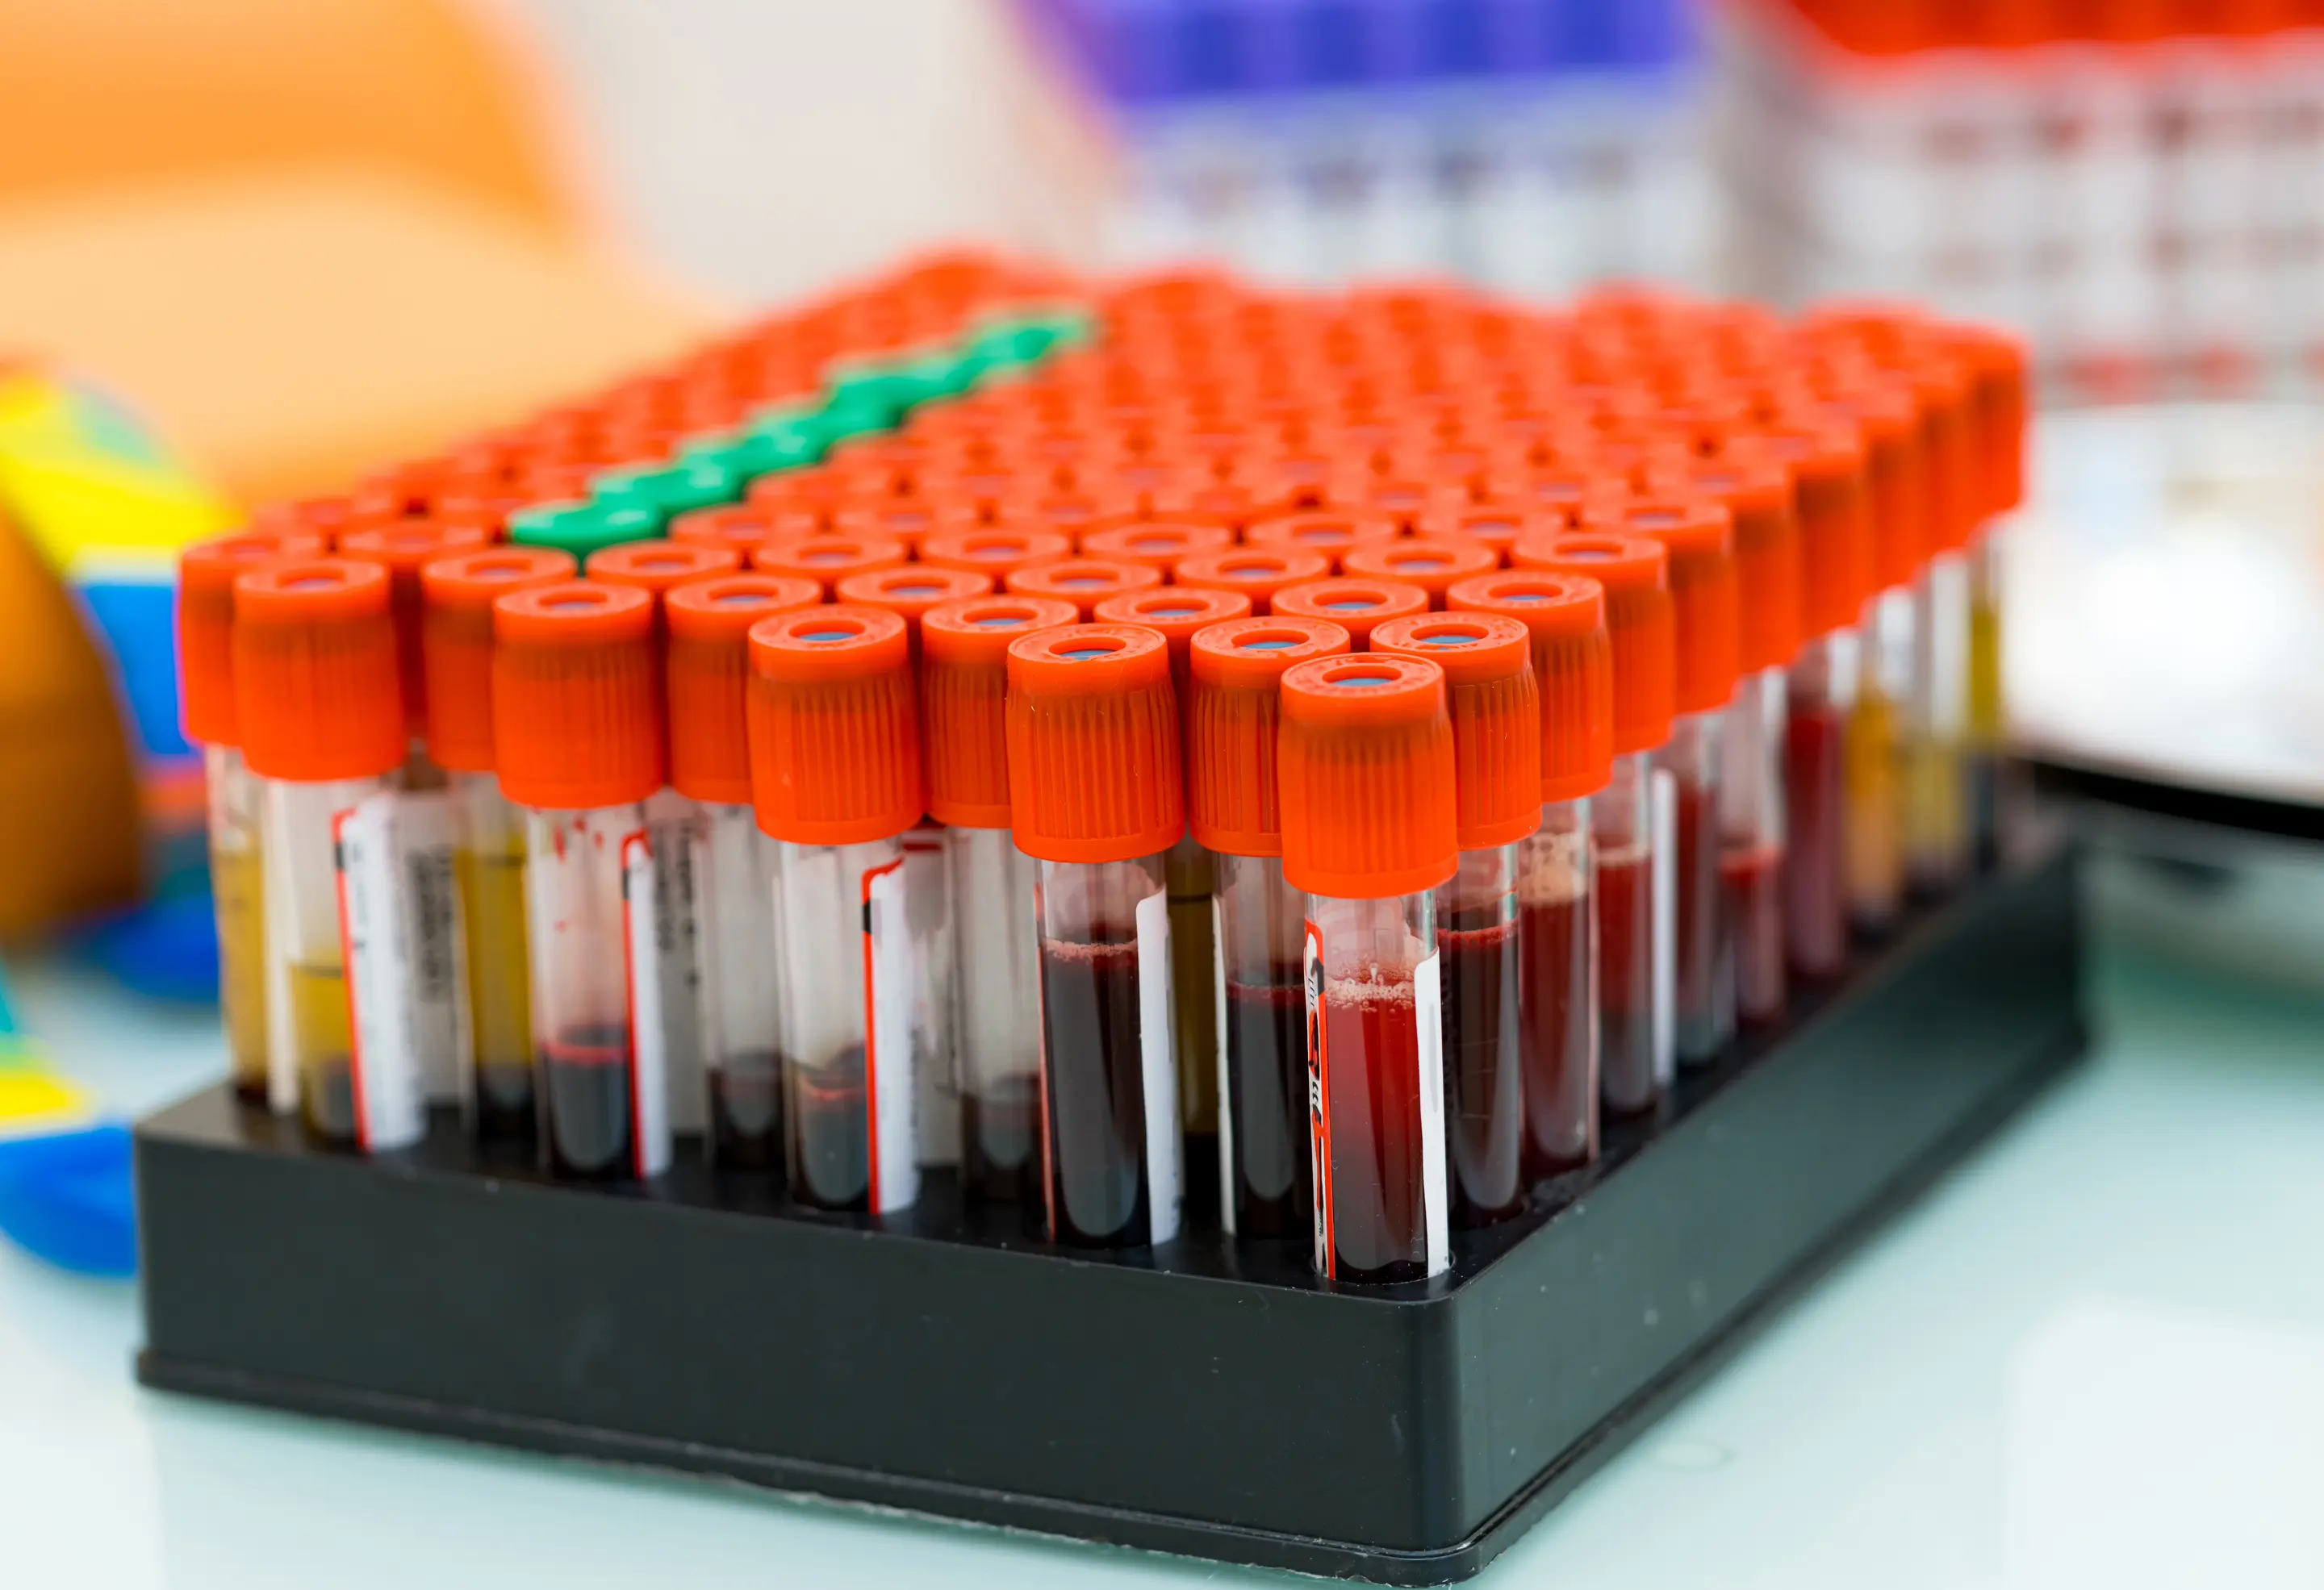

---

# B. Setup, Cleaning, and EDA

## B1. Setup

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
sns.set(style="darkgrid")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
data = pd.read_csv('test_project_data.csv')
data.head()

,subject_id,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018326,mtb_0018327,mtb_0018351,mtb_0018362,mtb_0018470,mtb_0018509,...,mtb_2127305,mtb_2129124,mtb_2129210,mtb_2129554,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
0,sbj_0000,5885.011,15177.95,19653.31,12611.670,9042.063,NaN,60124.56,9552.881,NaN,...,NaN,NaN,22112.25,NaN,18.664268,33.81,male,0.0,0.0,14.77
1,sbj_0001,7624.425,10901.94,12129.36,9336.460,21680.930,NaN,83700.80,15068.120,NaN,...,NaN,NaN,NaN,NaN,28.175977,68.56,male,0.0,0.0,14.77
2,sbj_0002,7220.400,18086.69,23707.55,7344.697,26314.650,NaN,82482.38,13911.300,NaN,...,15185.790,NaN,19425.35,NaN,22.971959,55.68,male,0.0,0.0,14.77
3,sbj_0003,6797.486,12364.85,17775.76,25836.150,30563.140,NaN,92839.12,11690.130,NaN,...,NaN,NaN,NaN,NaN,21.960370,43.89,female,0.0,0.0,14.78
4,sbj_0004,NaN,19046.33,18701.06,14137.270,27020.920,NaN,85453.69,9579.896,NaN,...,5318.547,NaN,NaN,NaN,40.454949,47.76,male,0.0,0.0,14.86


In [3]:
non_mtb_columns = [column for column in data.columns if not column.startswith("mtb")]
print(f"There are {len(non_mtb_columns)} columns that are not blood biomarkers and they are: \n {non_mtb_columns}")

There are 7 columns that are not blood biomarkers and they are: 
 ['subject_id', 'BMI', 'age', 'sex', 'prevalent_diabetes', 'incident_diabetes', 'diabetes_followup_time']


IMPORTANT NOTE: To avoid any ambiguity, it seems that in the project description, 'existing_diabetes' corresponds to 'prevalent_diabetes,' and 'diabetes_time' aligns with 'diabetes_followup_time.'

In [4]:
mtb_columns = [column for column in data.columns if column.startswith("mtb")]
mtb_columns_count = len(mtb_columns)
print(f"Number of blood biomarkers included: {mtb_columns_count}")

Number of blood biomarkers included: 10000


## B2. Cleaning: Checking for Duplicates

Let's ensure there are no duplicate blood biomarkers included in the dataset.

In [5]:
data.columns.duplicated().sum()

0

Let's also, of course, check for duplicate subject id values. 

In [6]:
data.duplicated().sum()

0

## B3. Cleaning: Missing Values

Given that nulls in mtb_columns are usually due to the extremely low abundance of that biomarker in blood samples which could be below the lower limit of detection, we will fill in 0 for all null values in these columns.

In [7]:
#fill nulls in blood biomarker columns with 0 
data[mtb_columns] = data[mtb_columns].fillna(0)

In [8]:
data.isna().sum().sort_values(ascending=False).head(10)

diabetes_followup_time    312
prevalent_diabetes        143
incident_diabetes         143
BMI                         4
mtb_0649415                 0
mtb_0651209                 0
mtb_0650958                 0
mtb_0650891                 0
mtb_0650727                 0
mtb_0650179                 0
dtype: int64

Let's take care of null values in diabetes_followup_time, prevalent_diabetes, incident_diabetes, and BMI. 

In [9]:
#fill null values in 'diabetes_followup_time' with 0
data['diabetes_followup_time'].fillna(0, inplace=True)

#fill null values in 'BMI' with the average BMI
average_bmi = data['BMI'].mean()
data['BMI'].fillna(average_bmi, inplace=True)

Let's also drop any values in the dataset where our target value is null, which may take care of the prevalent_diabetes null values as well.

In [10]:
data = data.dropna(subset=['incident_diabetes'])

In [11]:
data.isna().sum().sort_values(ascending=False).head(5)

diabetes_followup_time    0
mtb_0649415               0
mtb_0651209               0
mtb_0650958               0
mtb_0650891               0
dtype: int64

Great - All clear with missing values! 

Last, let's one hot encode our sex column so that our values are all numeric.

In [12]:
data = pd.get_dummies(data, columns=['sex'], drop_first=True)

Sanity check.

In [13]:
data.head(20)

,subject_id,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018326,mtb_0018327,mtb_0018351,mtb_0018362,mtb_0018470,mtb_0018509,...,mtb_2127305,mtb_2129124,mtb_2129210,mtb_2129554,BMI,age,prevalent_diabetes,incident_diabetes,diabetes_followup_time,sex_male
0,sbj_0000,5885.011,15177.950,19653.310,12611.670,9042.063,0.0,60124.56,9552.881,0.0,...,0.000,0.0,22112.25,0.0,18.664268,33.81,0.0,0.0,14.77,1
1,sbj_0001,7624.425,10901.940,12129.360,9336.460,21680.930,0.0,83700.80,15068.120,0.0,...,0.000,0.0,0.00,0.0,28.175977,68.56,0.0,0.0,14.77,1
2,sbj_0002,7220.400,18086.690,23707.550,7344.697,26314.650,0.0,82482.38,13911.300,0.0,...,15185.790,0.0,19425.35,0.0,22.971959,55.68,0.0,0.0,14.77,1
3,sbj_0003,6797.486,12364.850,17775.760,25836.150,30563.140,0.0,92839.12,11690.130,0.0,...,0.000,0.0,0.00,0.0,21.960370,43.89,0.0,0.0,14.78,0
4,sbj_0004,0.000,19046.330,18701.060,14137.270,27020.920,0.0,85453.69,9579.896,0.0,...,5318.547,0.0,0.00,0.0,40.454949,47.76,0.0,0.0,14.86,1
5,sbj_0005,6688.659,7881.781,14732.830,0.000,19656.300,0.0,82202.27,0.000,0.0,...,0.000,0.0,17394.59,0.0,30.885967,47.38,0.0,0.0,14.86,1
6,sbj_0006,6071.828,14438.800,23778.560,16961.380,28634.590,0.0,89656.71,13672.150,0.0,...,5232.656,0.0,0.00,0.0,26.831060,34.11,0.0,0.0,14.86,0
7,sbj_0007,7687.997,8332.878,16874.280,25245.530,24130.120,0.0,89309.79,7823.137,0.0,...,0.000,0.0,0.00,0.0,24.584382,52.62,0.0,0.0,14.86,0
8,sbj_0008,6381.261,11864.460,9896.124,5710.429,23579.490,0.0,78010.90,9099.404,0.0,...,6486.551,0.0,0.00,0.0,32.996551,32.73,0.0,1.0,7.88,1
9,sbj_0009,6033.921,7012.418,11552.380,4453.409,4612.332,0.0,71858.77,12555.820,0.0,...,0.000,0.0,0.00,0.0,32.822190,29.56,0.0,0.0,14.88,1


Looks all clean! Now let's explore.

## B4. Exploratory Data Analysis

Let's examine counts for: (1) diabetes before the study commenced, (2) diabetes that developed during the study, and (3) the overall presence of diabetes—both before and during the study.

In [14]:
#total number of participants
total_participants = data['subject_id'].count()
print(f"There are {total_participants} total participants in this study.")

There are 8148 total participants in this study.


In [15]:
#count of people with diabetes before the study commenced
data['prevalent_diabetes'].sum()

451.0

Sanity check.

In [16]:
#count of people with or without diabetes before the study commenced 
data['prevalent_diabetes'].value_counts()

0.0    7697
1.0     451
Name: prevalent_diabetes, dtype: int64

In [17]:
#percentage of people with or without diabetes before the study commenced 
(data['prevalent_diabetes'].value_counts(normalize=True) * 100).round(2)

0.0    94.46
1.0     5.54
Name: prevalent_diabetes, dtype: float64

In [18]:
print(f"Of the {total_participants} participants, {(data['prevalent_diabetes'].value_counts(normalize=True) * 100).round(2)[1]}% (or {data['prevalent_diabetes'].value_counts()[1]} participants) had diabetes when the study began.")

Of the 8148 participants, 5.54% (or 451 participants) had diabetes when the study began.


Let's plot prevalent diabetes counts.

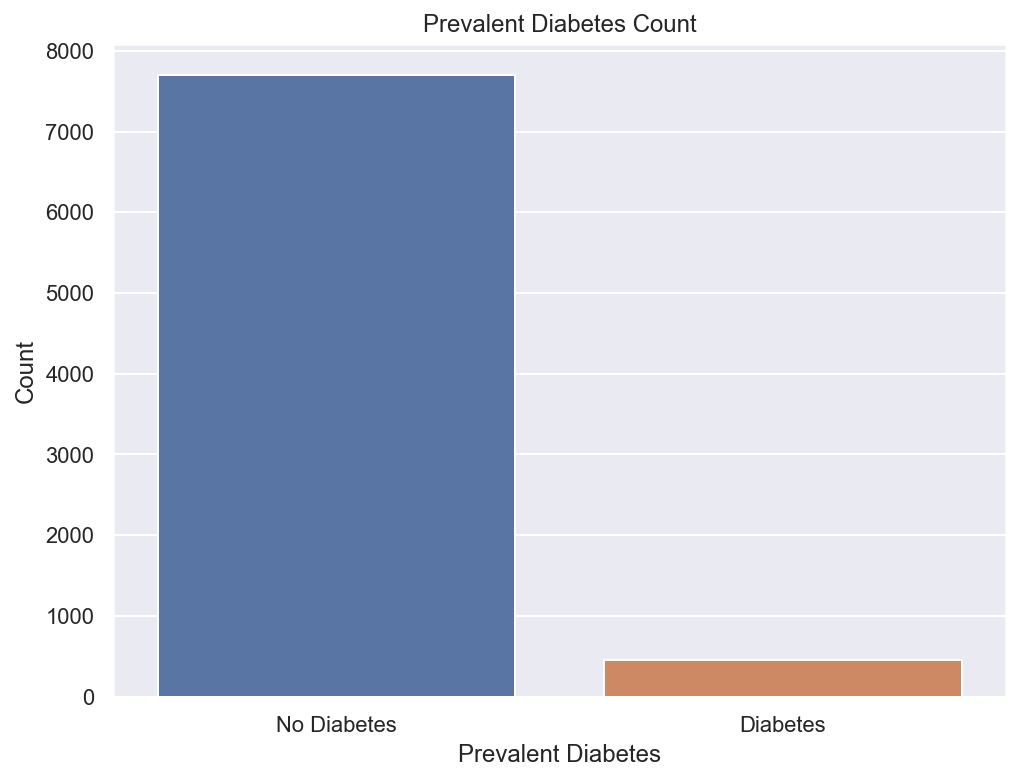

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='prevalent_diabetes', data=data)

plt.title('Prevalent Diabetes Count')
plt.xlabel('Prevalent Diabetes')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

plt.show()

In [20]:
#count of people who developed diabetes during the study
data['incident_diabetes'].sum()

704.0

In [21]:
#count of people who did or did not develop diabetes during the study
data['incident_diabetes'].value_counts()

0.0    7444
1.0     704
Name: incident_diabetes, dtype: int64

In [22]:
#percentage of people who did or did not develop diabetes during the study
(data['incident_diabetes'].value_counts(normalize=True) * 100).round(2)

0.0    91.36
1.0     8.64
Name: incident_diabetes, dtype: float64

In [23]:
print(f"Of the {total_participants} participants, {(data['incident_diabetes'].value_counts(normalize=True) * 100).round(2)[1]}% (or {data['incident_diabetes'].value_counts()[1]} participants) developed diabetes during the study. This is the target variable that our project is interested in.")

Of the 8148 participants, 8.64% (or 704 participants) developed diabetes during the study. This is the target variable that our project is interested in.


Assumption Flag: I am assuming that participants who had diabetes at baseline are not included in "incident_diabetes." Therefore, out of curiosity, we will next explore the count for all participants with diabetes. 

Let's plot incident diabetes counts.

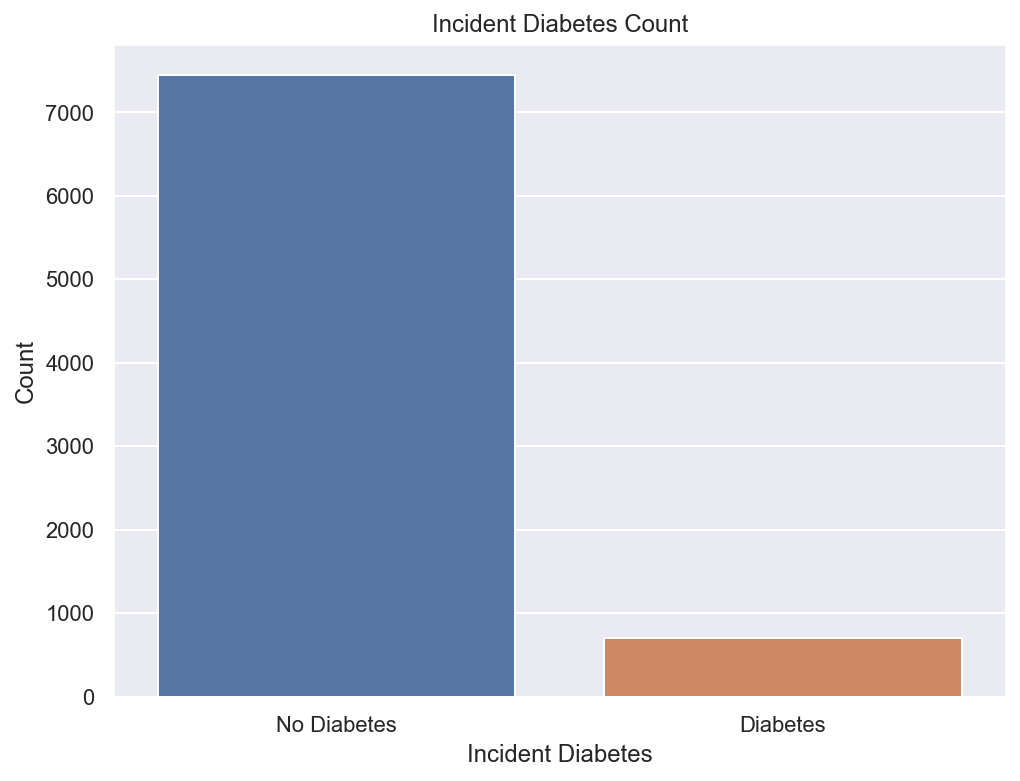

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(x='incident_diabetes', data=data)

plt.title('Incident Diabetes Count')
plt.xlabel('Incident Diabetes')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

plt.show()

In [25]:
#count of people who have diabetes by the end of the study, whether they developed it before or during the study
total_diabetes = (data['prevalent_diabetes'] == 1).sum() + (data['incident_diabetes'] == 1).sum()
total_diabetes

1155

Let's plot the count of people who have diabetes by the end of the study, whether they developed it before or during the study.

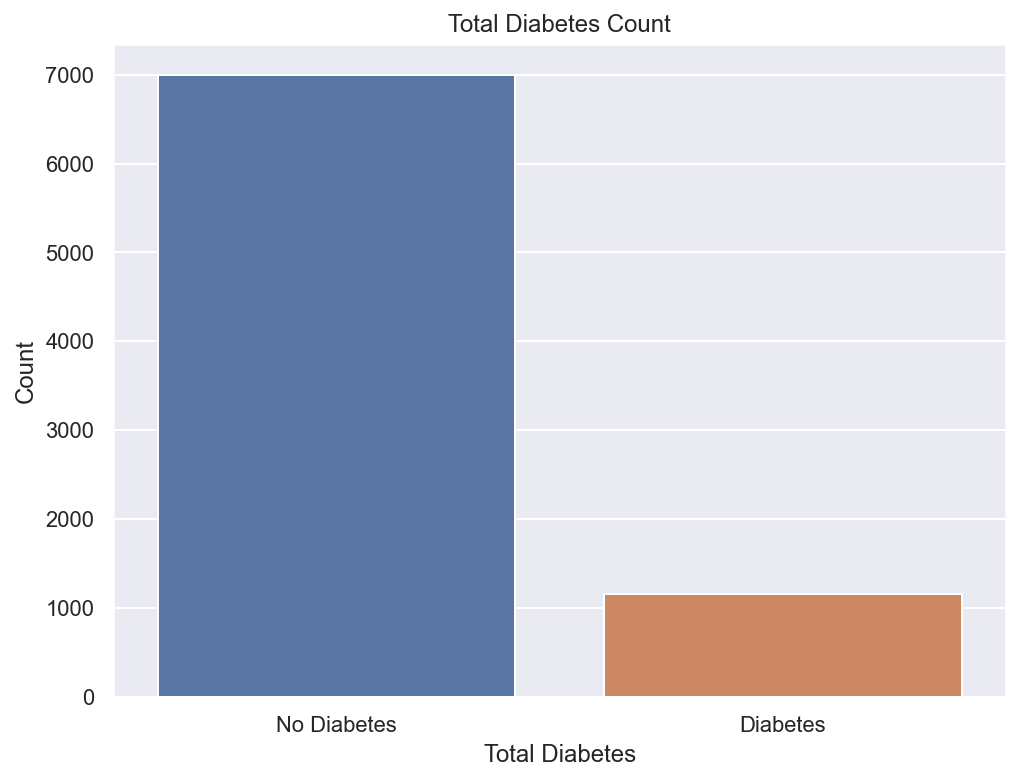

In [26]:
counts_data = {'Total Diabetes': ['No Diabetes', 'Diabetes'],
               'Count': [(total_participants - total_diabetes), total_diabetes]}
counts_df = pd.DataFrame(counts_data)

plt.figure(figsize=(8, 6))
sns.barplot(x='Total Diabetes', y='Count', data=counts_df)

plt.title('Total Diabetes Count')
plt.xlabel('Total Diabetes')
plt.ylabel('Count')

plt.show()

It is worth flagging when looking at these counts and percentages of participants with diabetes that we may have issues due to class imbalance. We will need to keep this in mind as we move into analysis.

---

# C. Q1: Which blood biomarkers are associated with incident diabetes?

Each of these biomarkers can potentially be a risk or protective factor for diabetes development. Identifiying these biomarkers will help understand the pathways and processes involved in diabetes development thus novel therapeutics can be developed.

Hints: 
- (1) Investigate each blood biomarker individually with covariates and use p-values to justify your findings.
- (2) For blood biomarkers, use transformation that is robust when there are outliers present. 
- (3) Demonstrate your findings with visualization.

---

## C1. Linear Regressions for Each Blood Biomarker

In [27]:
covariates = ['BMI', 'age', 'sex_male', 'prevalent_diabetes', 'diabetes_followup_time']
results = []

for biomarker in mtb_columns:
    #applying log transformation to biomarker data to compress the range of values 
    #and make it less sensitive to extreme values
    X_transformed = np.log1p(data[biomarker])
    X = sm.add_constant(pd.concat([X_transformed, data[covariates]], axis=1))
    model = sm.OLS(data['incident_diabetes'], X).fit()

    result_dict = {
        'biomarker': biomarker,
        'p-value': model.pvalues[1],
        'coef': model.params[1]
    }
    results.append(result_dict)

results_df = pd.DataFrame(results)

In [28]:
results_df.head(10)

,biomarker,p-value,coef
0,mtb_0018261,0.716443,0.000278
1,mtb_0018266,0.268296,0.000657
2,mtb_0018325,0.975326,0.000021
3,mtb_0018326,0.122823,0.000853
4,mtb_0018327,0.448527,-0.000411
5,mtb_0018351,0.952236,0.000038
6,mtb_0018362,0.071666,0.013842
7,mtb_0018470,0.523988,0.000350
8,mtb_0018509,0.873893,-0.000103
9,mtb_0018536,0.597899,0.000465


## C2. Investigating P-Values

- Null Hypothesis (H0): No correlation exists between the given biomarker and incident_diabetes.
- Alternative Hypothesis (H1): Correlation exists between the given biomarker and incident_diabetes. 

In [29]:
significant_biomarkers_05 = results_df[results_df['p-value'] < 0.05]
significant_biomarkers_01 = results_df[results_df['p-value'] < 0.01]
significant_biomarkers_001 = results_df[results_df['p-value'] < 0.001]

In [30]:
print(f"At an alpha of .05, we have {len(significant_biomarkers_05)} statistically significant biomarkers.")
print(f"At an alpha of .01, we have {len(significant_biomarkers_01)} statistically significant biomarkers.")
print(f"At an alpha of .001, we have {len(significant_biomarkers_001)} statistically significant biomarkers.")

At an alpha of .05, we have 1282 statistically significant biomarkers.
At an alpha of .01, we have 595 statistically significant biomarkers.
At an alpha of .001, we have 225 statistically significant biomarkers.


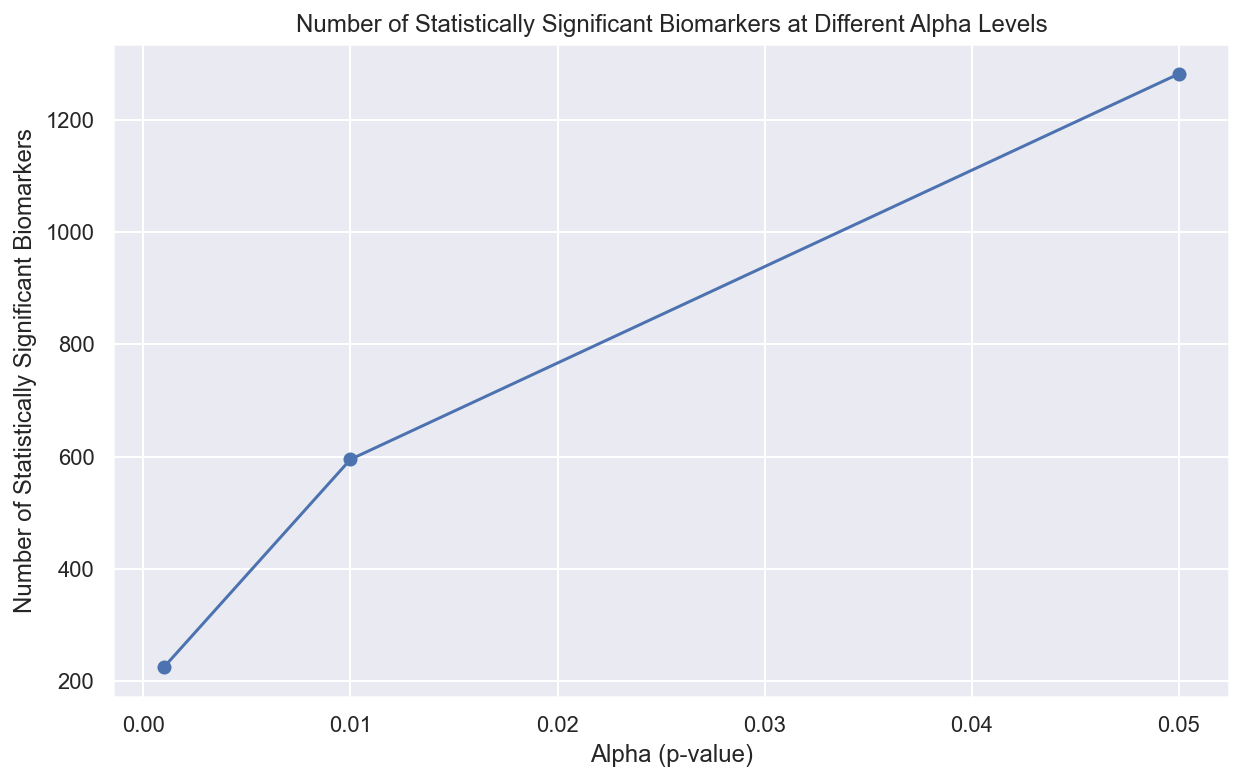

In [35]:
alphas = [0.05, 0.01, 0.001]
significant_biomarkers = [len(significant_biomarkers_05), len(significant_biomarkers_01), len(significant_biomarkers_001)]

plt.figure(figsize=(10, 6))
plt.plot(alphas, significant_biomarkers, marker='o', linestyle='-')

plt.xlabel('Alpha (p-value)')
plt.ylabel('Number of Statistically Significant Biomarkers')
plt.title('Number of Statistically Significant Biomarkers at Different Alpha Levels')

plt.show()

We must also consider blood biomarkers that are risk (positive correlation with incident_diabetes) and protective (negative correlation with incident diabetes) factors. Let's make sure to evaluate these separately.

In [31]:
top_positive_corr_biomarkers = significant_biomarkers_001.sort_values(by='coef', ascending=False)
top_negative_corr_biomarkers = significant_biomarkers_001.sort_values(by='coef', ascending=True)

### C3. Positive Coefficient with Incident Diabetes (RISK)

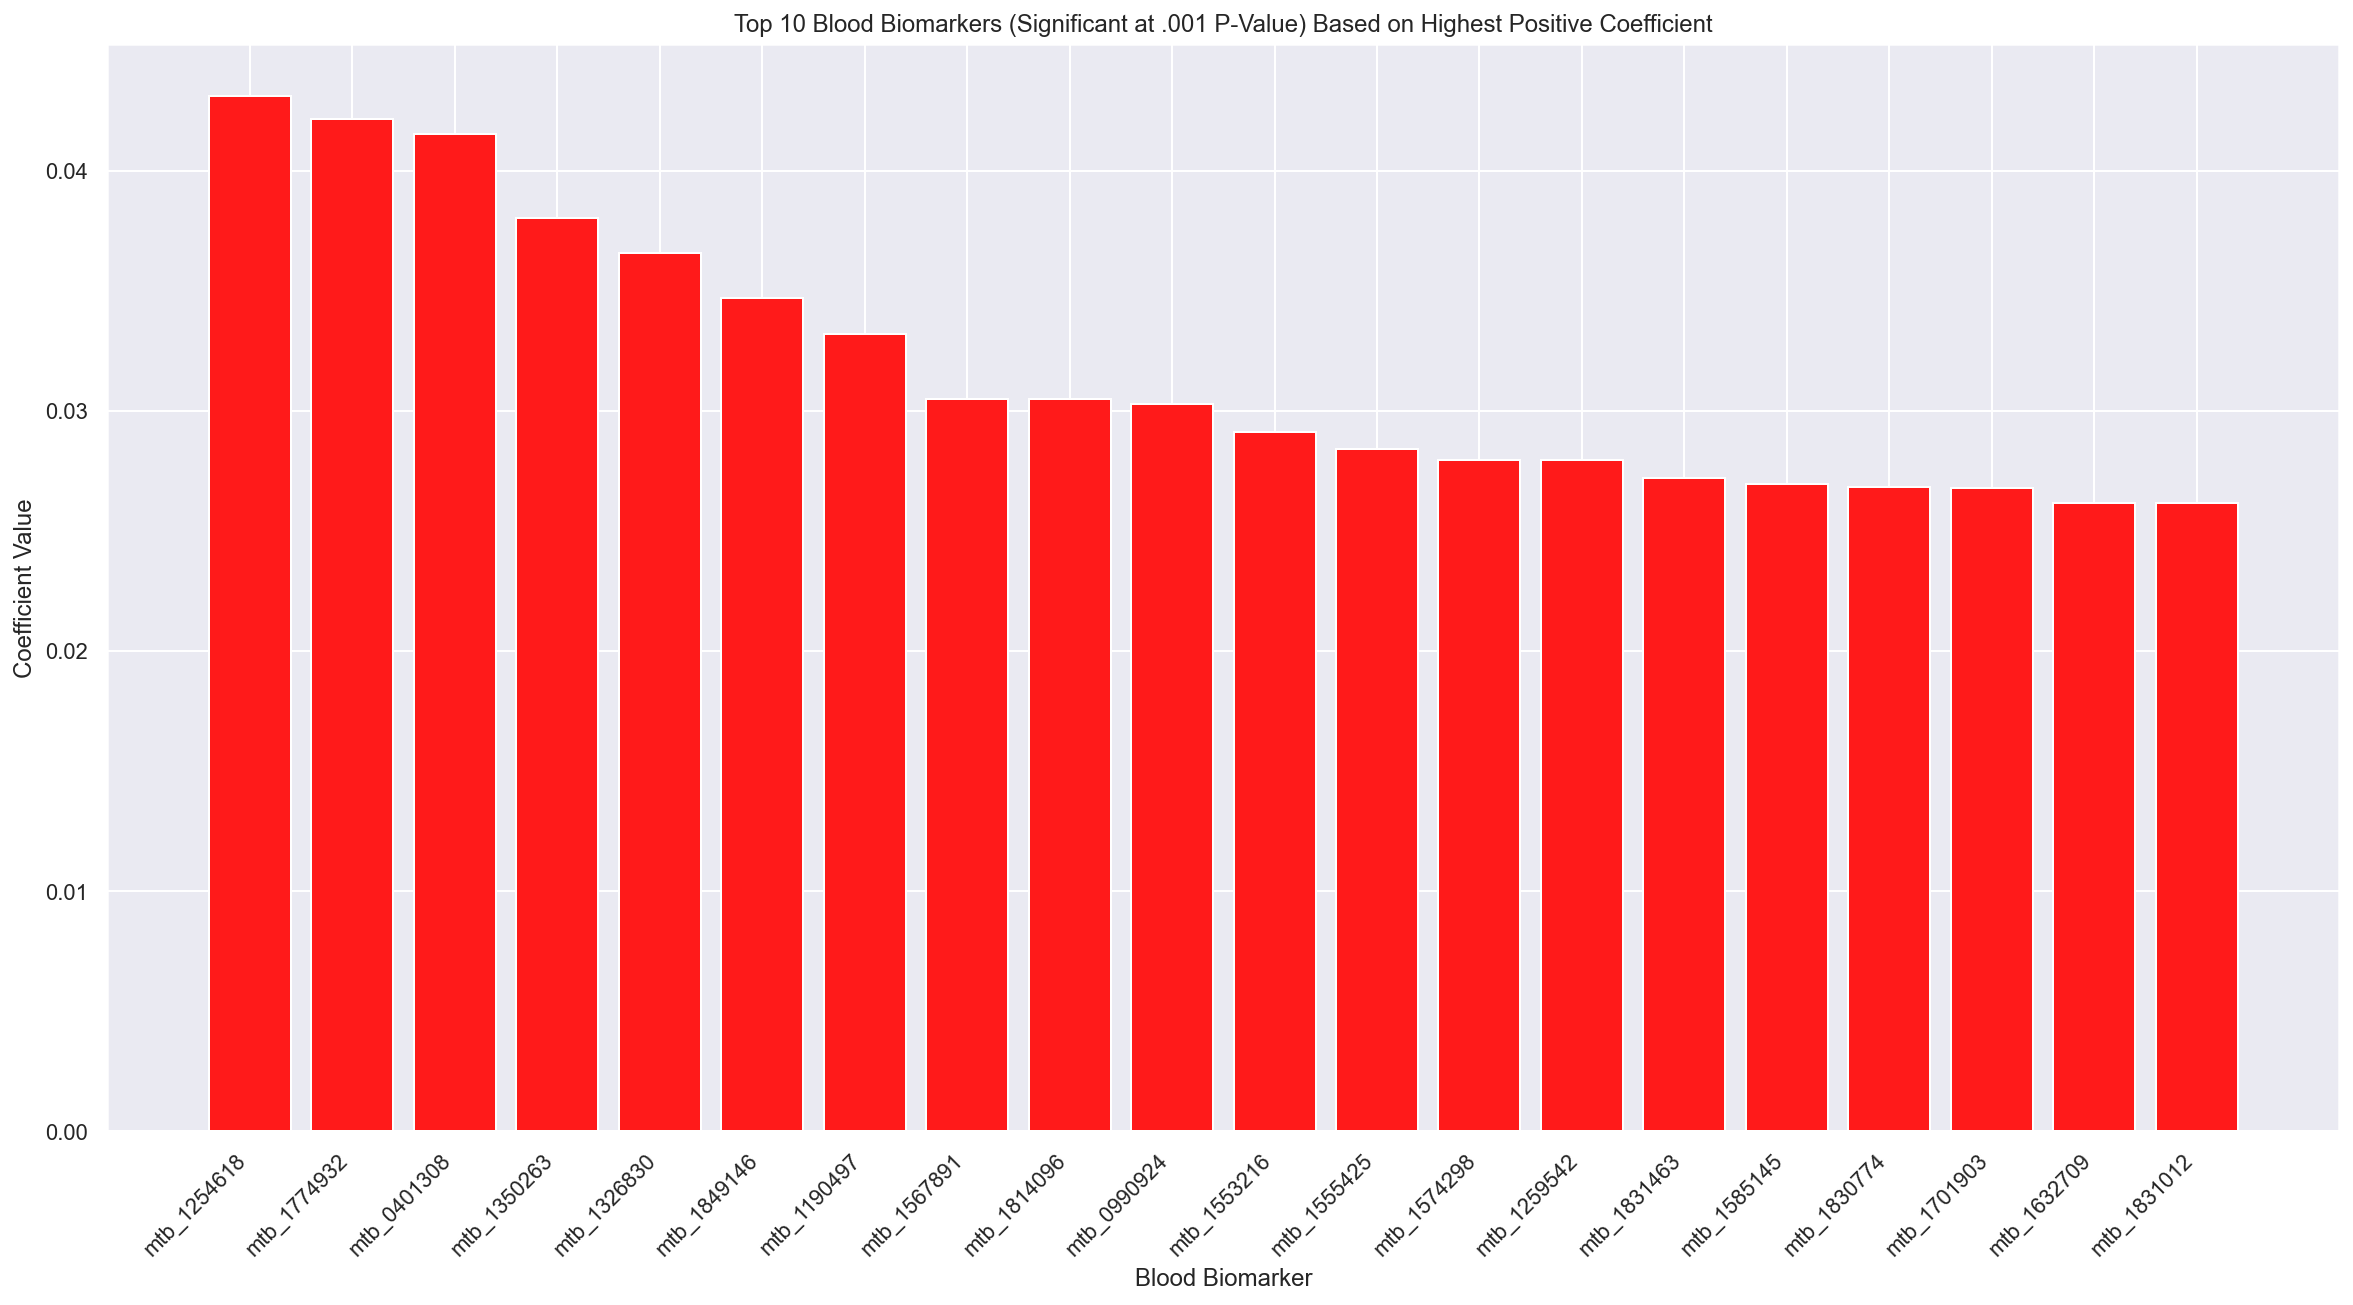

In [54]:
top_20_pos_corr_biomarkers = top_positive_corr_biomarkers.head(20)

plt.figure(figsize=(20, 10))
plt.bar(top_20_pos_corr_biomarkers['biomarker'], top_20_pos_corr_biomarkers['coef'], color=(1.0, 0.1, 0.1))
plt.ylabel('Coefficient Value')
plt.xlabel('Blood Biomarker')
plt.title('Top 10 Blood Biomarkers (Significant at .001 P-Value) Based on Highest Positive Coefficient')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

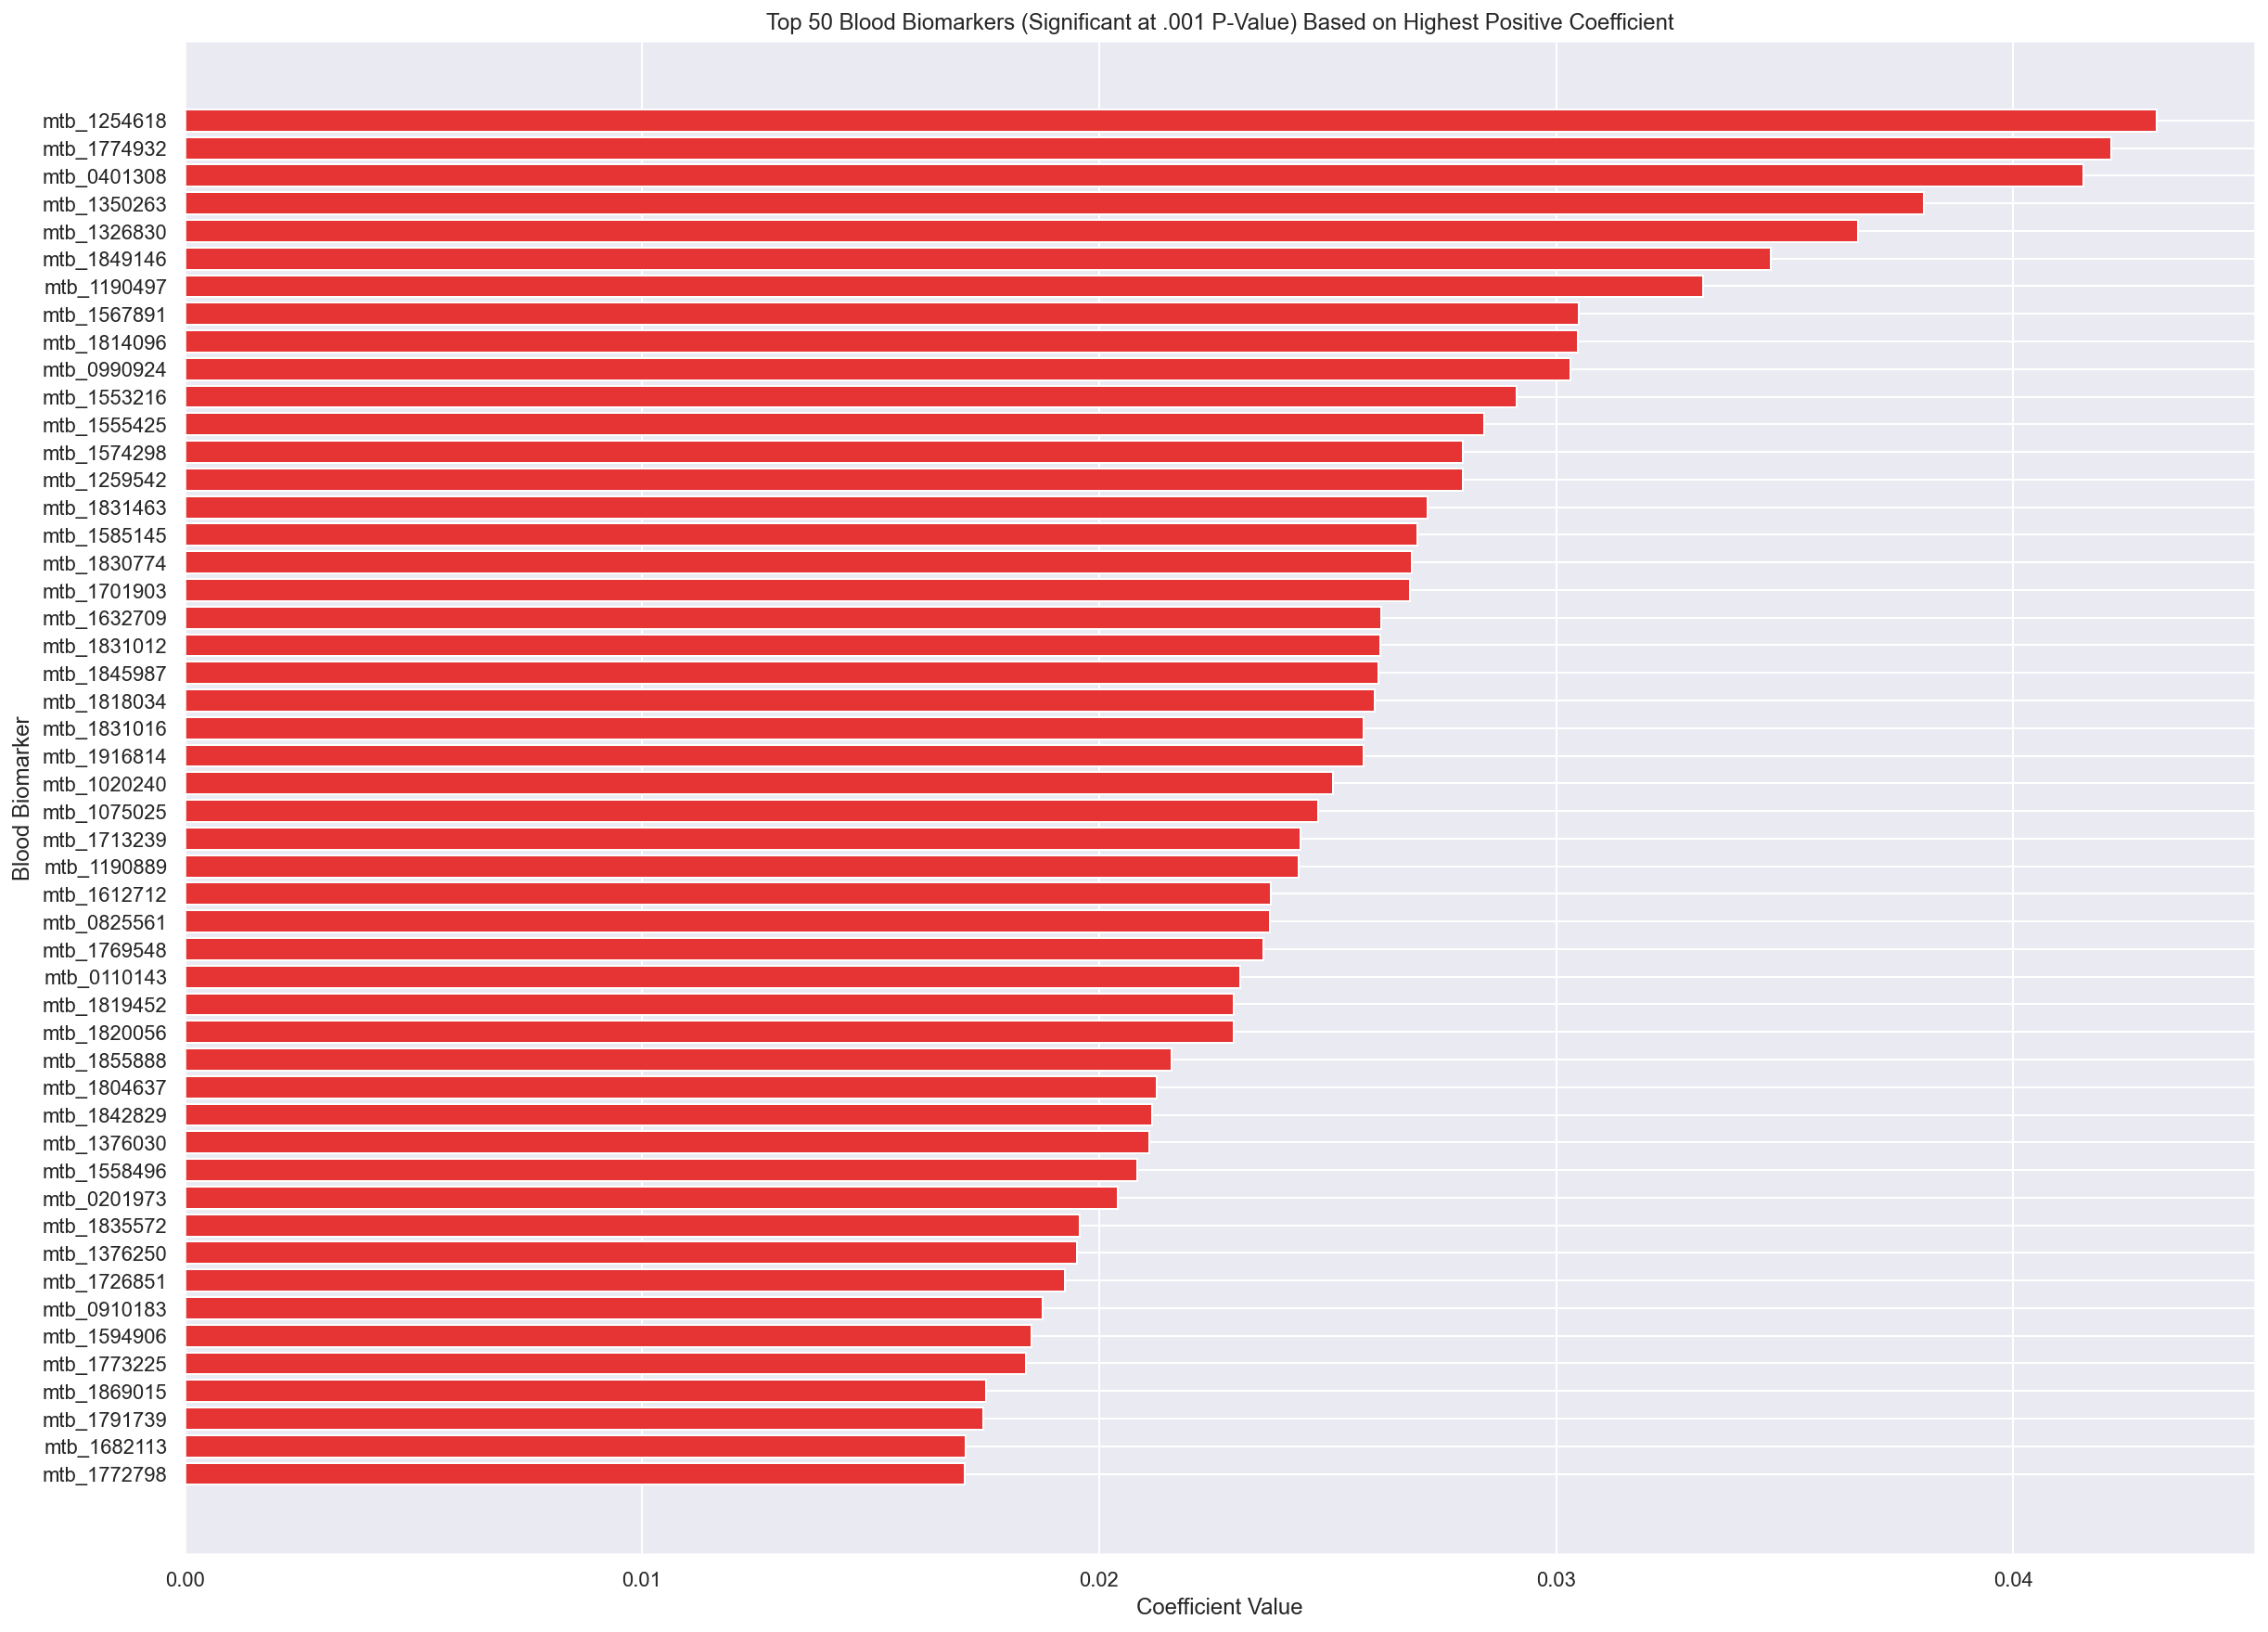

In [55]:
top_50_pos_corr_biomarkers = top_positive_corr_biomarkers.head(50)

plt.figure(figsize=(20, 15))
plt.barh(top_50_pos_corr_biomarkers['biomarker'], top_50_pos_corr_biomarkers['coef'], color=(0.9, 0.2, 0.2))
plt.xlabel('Coefficient Value')
plt.ylabel('Blood Biomarker')
plt.title('Top 50 Blood Biomarkers (Significant at .001 P-Value) Based on Highest Positive Coefficient')
plt.gca().invert_yaxis()
plt.show()

## C4. Negative Coefficient with Incident Diabetes (PROTECTIVE)

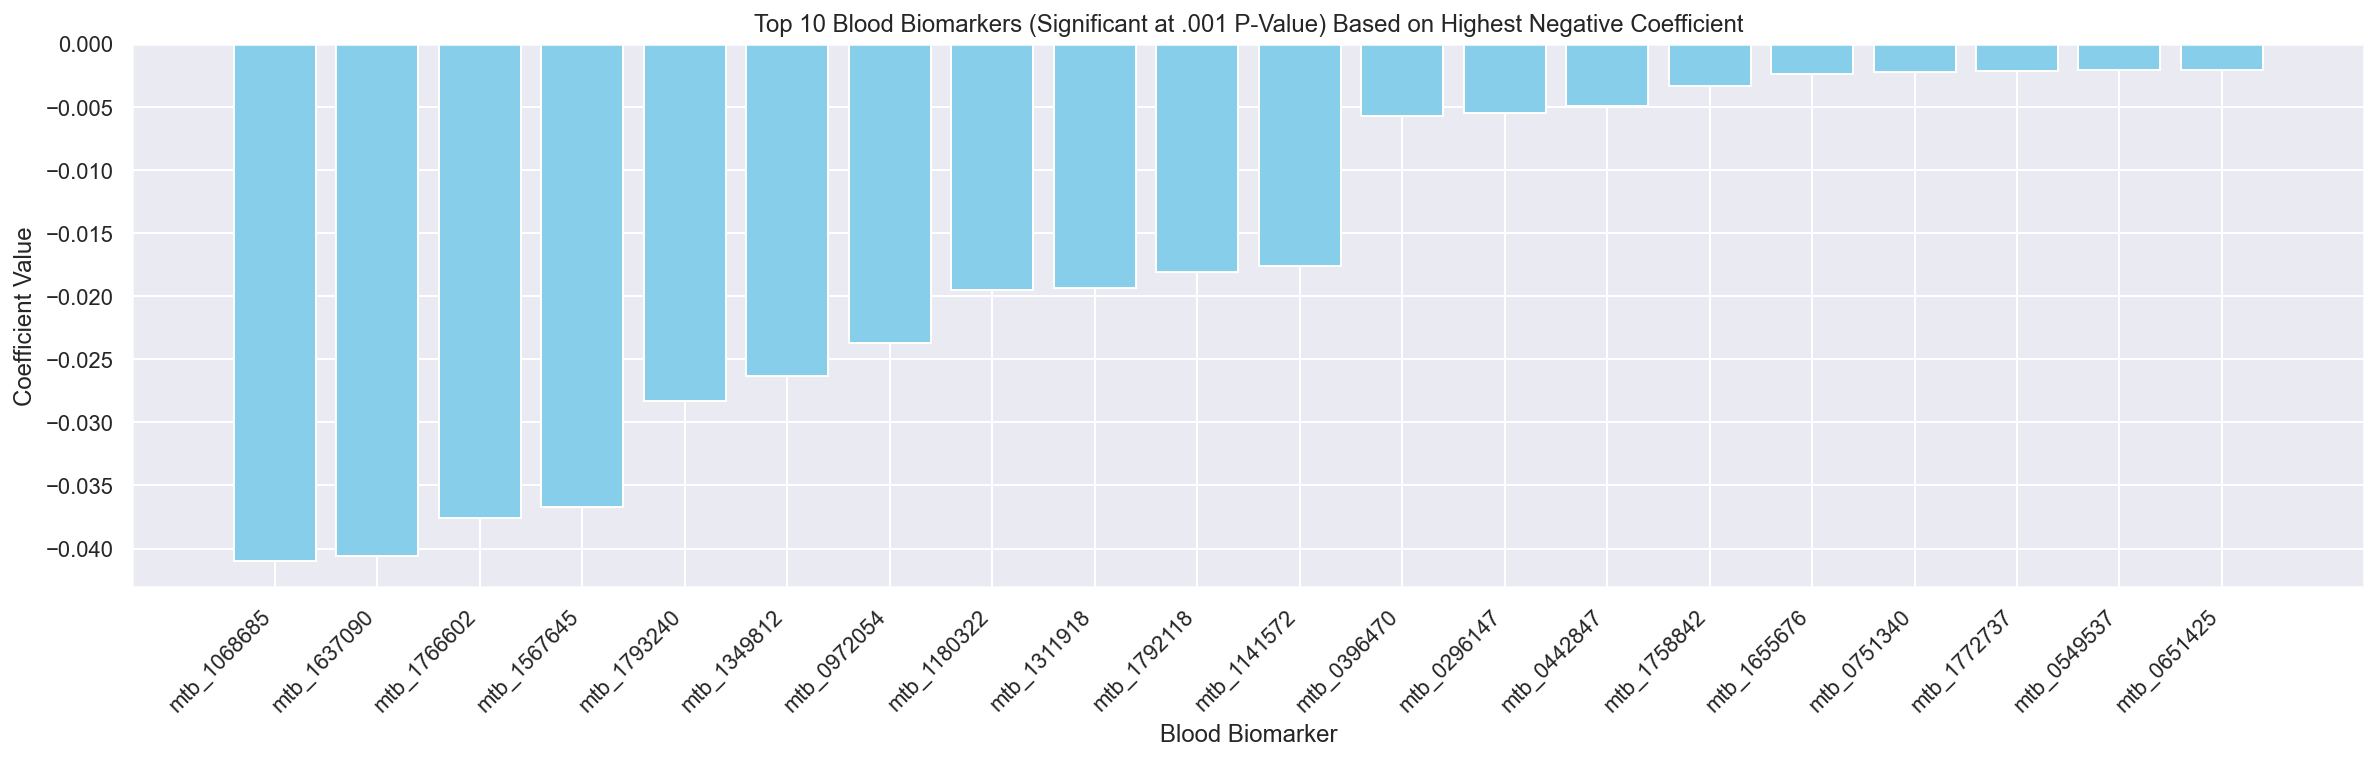

In [60]:
top_20_neg_corr_biomarkers = top_negative_corr_biomarkers.head(20)

plt.figure(figsize=(20, 5))
plt.bar(top_20_neg_corr_biomarkers['biomarker'], top_20_neg_corr_biomarkers['coef'], color='skyblue')
plt.ylabel('Coefficient Value')
plt.xlabel('Blood Biomarker')
plt.title('Top 10 Blood Biomarkers (Significant at .001 P-Value) Based on Highest Negative Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

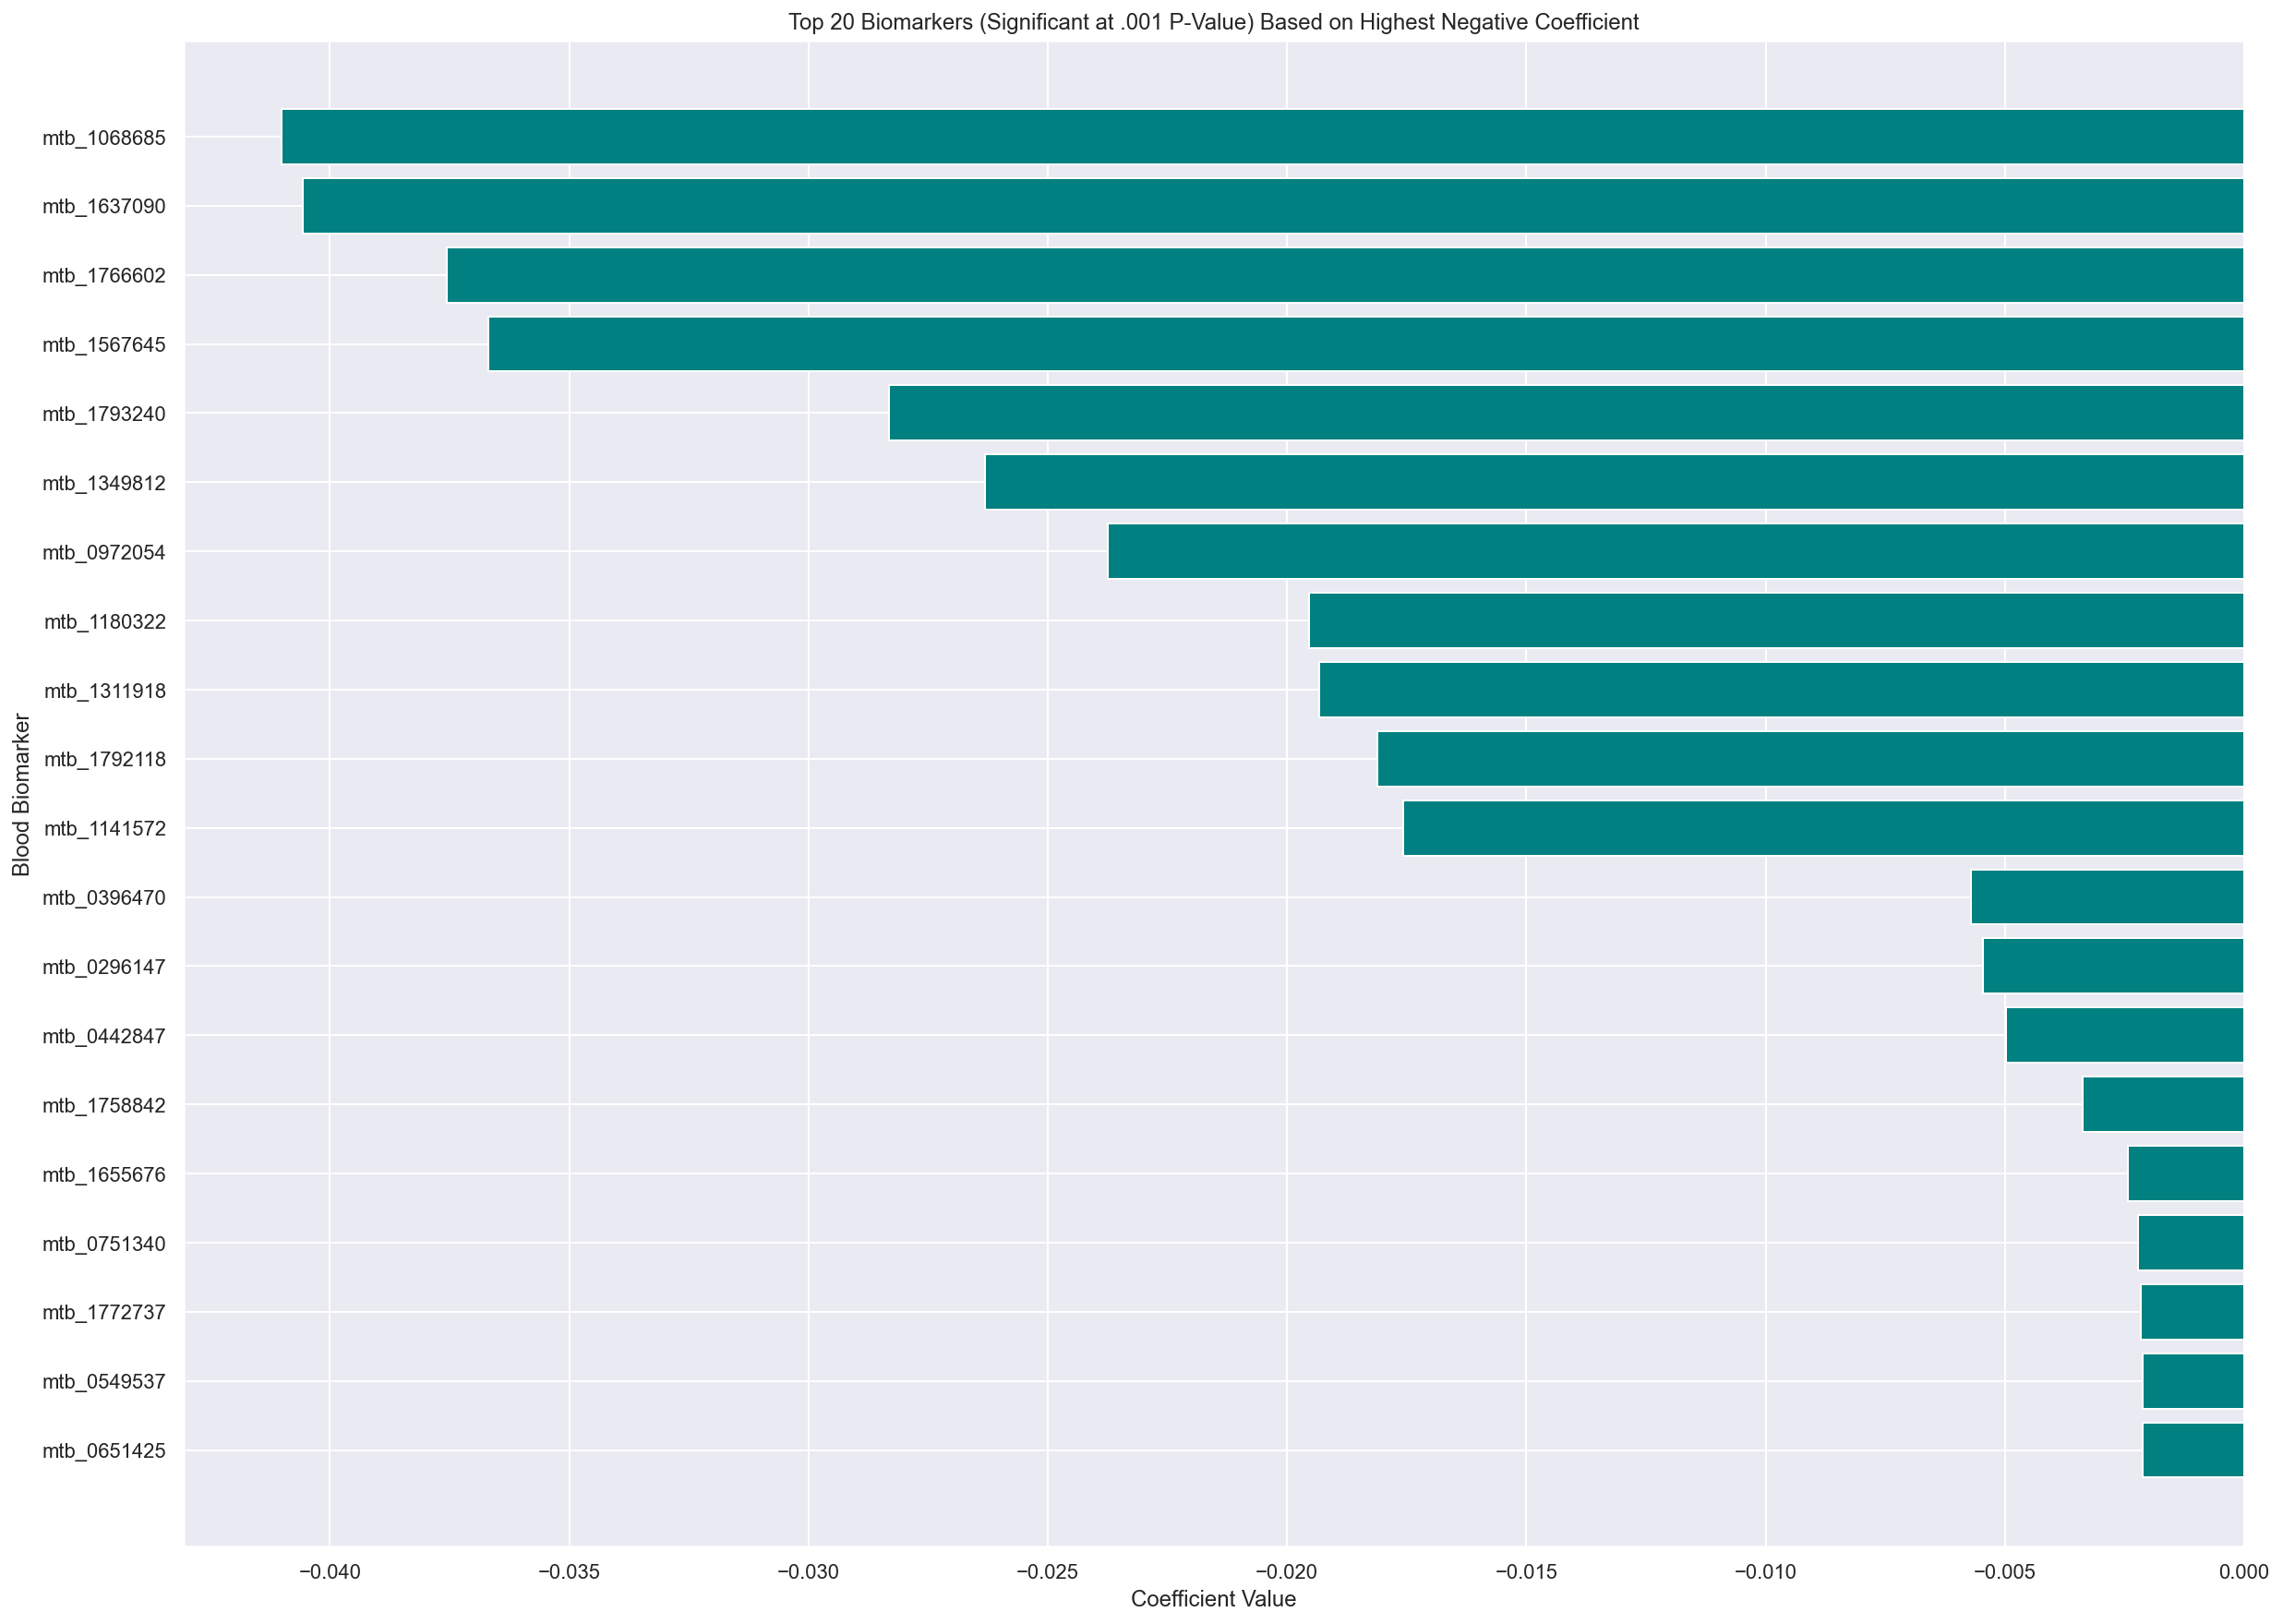

In [57]:
top_20_neg_corr_biomarkers = top_negative_corr_biomarkers.head(20)

plt.figure(figsize=(20, 15))
plt.barh(top_20_neg_corr_biomarkers['biomarker'], top_20_neg_corr_biomarkers['coef'], color='teal')
plt.xlabel('Coefficient Value')
plt.ylabel('Blood Biomarker')
plt.title('Top 20 Biomarkers (Significant at .001 P-Value) Based on Highest Negative Coefficient')
plt.gca().invert_yaxis()
plt.show()

---

# D. Q2: How can we use blood biomarkers to predict the risk of developing incident diabetes?

Hints: 
- (1) Select the relevant blood biomarkers as features for your classifier. Keep in mind that in clinical settings, it is always difficult to implement a screening test when there are a lot of biomarkers to be measured. 
- (2) Select and train a machine learning model to make predictions
- (3) Evaluate your predictive model.

Explanation of Models: For our machine learning model, we will initially employ logistic regression with hyperparameters tuned specifically for all blood biomarkers at three alpha levels: 0.05, 0.01, and 0.001. Additionally, we will explore the effectiveness of a K Nearest Neighbors model for blood biomarkers deemed statistically significant at all three p-values. Consequently, there will be a total of six models, with three dedicated to each algorithm.

## D1. Vanilla LogReg Model for Blood Biomarkers Statistically Significant at .05 Alpha

In [37]:
selected_biomarkers_data_05 = data[['incident_diabetes'] + list(significant_biomarkers_05['biomarker'])]
selected_biomarkers_data_05

,incident_diabetes,mtb_0019710,mtb_0020812,mtb_0023385,mtb_0025408,mtb_0025572,mtb_0025608,mtb_0030396,mtb_0032732,mtb_0032933,...,mtb_1927454,mtb_1952330,mtb_1963745,mtb_1985184,mtb_1991935,mtb_1997248,mtb_2018298,mtb_2056383,mtb_2094209,mtb_2120885
0,0.0,44738.50,9504.184,18624.87,0.000,13749.86,0.0,27165.97,4090.245,0.0,...,8067.774,71744.47,0.0,23194.040,9604.280,0.000,0.0,0.000,0.000,0.000
1,0.0,82826.64,21842.630,16574.12,393.949,34090.73,0.0,24480.55,0.000,0.0,...,17912.580,0.00,0.0,56593.570,22865.420,0.000,0.0,0.000,0.000,0.000
2,0.0,95169.78,13915.450,13436.33,0.000,15300.68,0.0,17851.81,2029.257,0.0,...,0.000,125321.70,0.0,16107.070,10122.540,0.000,0.0,0.000,0.000,0.000
3,0.0,95722.26,29649.980,5830.32,1922.532,17993.70,0.0,11044.01,0.000,0.0,...,19266.460,84942.08,0.0,29123.100,10720.310,9055.233,0.0,0.000,0.000,0.000
4,0.0,91963.21,27045.690,10724.21,1135.911,22441.84,0.0,19294.46,0.000,0.0,...,13203.170,91254.91,0.0,54482.910,19147.750,0.000,0.0,3906.560,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,0.0,35502.37,7291.967,12398.41,0.000,11331.42,0.0,24136.83,3505.875,0.0,...,0.000,145625.00,0.0,0.000,3225.793,0.000,0.0,0.000,0.000,0.000
8287,0.0,86445.55,14939.750,12879.06,5919.530,27203.70,0.0,18765.93,0.000,0.0,...,0.000,34983.27,0.0,29660.910,14091.700,0.000,0.0,4547.782,8478.192,3103.647
8288,0.0,67046.64,21107.470,10248.63,0.000,9512.91,0.0,19699.47,0.000,0.0,...,0.000,40914.24,0.0,22475.970,8228.780,0.000,0.0,4960.176,0.000,0.000
8289,0.0,51289.32,6211.620,10835.28,0.000,26732.42,0.0,29859.98,0.000,0.0,...,4476.600,207477.00,0.0,9453.781,2798.269,0.000,0.0,1451.092,0.000,0.000


In [45]:
X = selected_biomarkers_data_05.drop(['incident_diabetes'], axis=1)
y = selected_biomarkers_data_05['incident_diabetes']

#normalize the data (X) before fitting the model
X = X.apply(lambda x:(x-x.min()) / (x.max() - x.min()), axis=0)
X.head()

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#instantiate a vanilla logistic regression model with max_iter to allow for the larger dataset
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs', max_iter=1000)

#fit the model
logreg.fit(X_train, y_train)

#generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

# calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_hat_train)
test_accuracy = accuracy_score(y_test, y_hat_test)

print(f'Training Accuracy: {(train_accuracy *100).round(2)}%')
print(f'Test Accuracy: {(test_accuracy *100).round(2)}%')

Training Accuracy: 100.0%
Test Accuracy: 83.25%


The training set is clearly overfit. The testing accuracy of 83% is not bad. Let's perform a gridsearch to identify our optimal hyperparameters. 

In [59]:
#did not have time to suppress errors
#define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

#instantiate logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs', max_iter=1000)

#create GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

#fit the model to the data
grid_search.fit(X_train, y_train)

#print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Training Accuracy: ", grid_search.best_score_)

#get the best model
best_model = grid_search.best_estimator_

#use the best model to make predictions on the test set
y_pred = best_model.predict(X_test)

#calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: ", test_accuracy)

Best Parameters:  {'C': 0.1, 'fit_intercept': True, 'max_iter': 100, 'solver': 'liblinear'}
Best Training Accuracy:  0.9140839450254015
Test Accuracy:  0.9116564417177914


The gridsearch reveals that the best parameters for the vanilla logistic regression model are: 
{'C': 0.1, 'fit_intercept': True, 'max_iter': 100, 'solver': 'liblinear'}

We will use these hyparameters for our 3 logistic regression models:
1. blood biomarkers statistically significant at .05 alpha
2. blood biomarkers statistically significant at .01 alpha
3. blood biomarkers statistically significant at .005 alpha


In [46]:
X = selected_biomarkers_data_05.drop(['incident_diabetes'], axis=1)
y = selected_biomarkers_data_05['incident_diabetes']

#normalize the data (X) before fitting the model
X = X.apply(lambda x:(x-x.min()) / (x.max() - x.min()), axis=0)
X.head()

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#instantiate a vanilla logistic regression model with max_iter to allow for the larger dataset
logreg = LogisticRegression(fit_intercept=True, C=.1, solver='liblinear', max_iter=100)

#fit the model
logreg.fit(X_train, y_train)

#generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

# calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_hat_train)
test_accuracy = accuracy_score(y_test, y_hat_test)

print(f'Training Accuracy: {(train_accuracy *100).round(2)}%')
print(f'Test Accuracy: {(test_accuracy *100).round(2)}%')

Training Accuracy: 91.78%
Test Accuracy: 91.04%


MODEL INTERPRETATION:
- It appears the model is no longer alarmingly overtfit with a training set accuracy of 91.78% and a testing set accuracy of 91.04%. This is much stronger than our logistic regression with adjusting hyperparameters. Let's take a look at blood biomarkers that are statistically significant at the .01 alpha level.

## D2. Vanilla LogReg Model for Blood Biomarkers Statistically Significant at .01 Alpha

In [38]:
selected_biomarkers_data_01 = data[['incident_diabetes'] + list(significant_biomarkers_01['biomarker'])]
selected_biomarkers_data_01

,incident_diabetes,mtb_0023385,mtb_0025408,mtb_0025572,mtb_0025608,mtb_0032933,mtb_0046860,mtb_0047817,mtb_0056818,mtb_0058377,...,mtb_1881432,mtb_1915423,mtb_1916814,mtb_1922702,mtb_1924734,mtb_1927454,mtb_1985184,mtb_2056383,mtb_2094209,mtb_2120885
0,0.0,18624.87,0.000,13749.86,0.0,0.0,0.0,12170.070,0.000,70283.18,...,0.00,9949.246,206314.2,0.000,0.000,8067.774,23194.040,0.000,0.000,0.000
1,0.0,16574.12,393.949,34090.73,0.0,0.0,0.0,4466.965,0.000,88897.01,...,0.00,6889.668,127788.9,7009.015,15031.840,17912.580,56593.570,0.000,0.000,0.000
2,0.0,13436.33,0.000,15300.68,0.0,0.0,0.0,0.000,3918.068,75633.46,...,34824.49,18718.990,142956.7,0.000,0.000,0.000,16107.070,0.000,0.000,0.000
3,0.0,5830.32,1922.532,17993.70,0.0,0.0,0.0,0.000,0.000,113598.10,...,0.00,6634.772,272361.2,0.000,5729.919,19266.460,29123.100,0.000,0.000,0.000
4,0.0,10724.21,1135.911,22441.84,0.0,0.0,0.0,0.000,4245.234,87552.45,...,0.00,14979.600,164424.0,0.000,0.000,13203.170,54482.910,3906.560,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,0.0,12398.41,0.000,11331.42,0.0,0.0,0.0,0.000,0.000,55576.14,...,0.00,50376.270,152969.9,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8287,0.0,12879.06,5919.530,27203.70,0.0,0.0,0.0,0.000,0.000,73116.46,...,0.00,36799.340,150372.5,9075.854,0.000,0.000,29660.910,4547.782,8478.192,3103.647
8288,0.0,10248.63,0.000,9512.91,0.0,0.0,0.0,0.000,0.000,70106.04,...,0.00,15642.800,123616.5,5676.967,0.000,0.000,22475.970,4960.176,0.000,0.000
8289,0.0,10835.28,0.000,26732.42,0.0,0.0,0.0,0.000,0.000,63344.23,...,206768.30,36292.300,112828.4,3839.037,0.000,4476.600,9453.781,1451.092,0.000,0.000


In [47]:
X = selected_biomarkers_data_01.drop(['incident_diabetes'], axis=1)
y = selected_biomarkers_data_01['incident_diabetes']

#normalize the data (X) before fitting the model
X = X.apply(lambda x:(x-x.min()) / (x.max() - x.min()), axis=0)
X.head()

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#instantiate a vanilla logistic regression model with max_iter to allow for the larger dataset
logreg = LogisticRegression(fit_intercept=True, C=.1, solver='liblinear', max_iter=100)

#fit the model
logreg.fit(X_train, y_train)

#generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

# calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_hat_train)
test_accuracy = accuracy_score(y_test, y_hat_test)

print(f'Training Accuracy: {(train_accuracy *100).round(2)}%')
print(f'Test Accuracy: {(test_accuracy *100).round(2)}%')

Training Accuracy: 91.59%
Test Accuracy: 91.17%


MODEL INTERPRETATION:
- The logistic regression model with optimal hyperparameters for blood biomarkers statistically significant at an alpha of .01 has a training accuracy of 91.59% and a test accuracy of 91.17%. Last, let's take a look at blood biomarkers statistically significant at an alpha of .001. 

## D3. Vanilla LogReg Model for Blood Biomarkers Statistically Significant at .001 Alpha

In [41]:
selected_biomarkers_data_001 = data[['incident_diabetes'] + list(significant_biomarkers_001['biomarker'])]
selected_biomarkers_data_001

,incident_diabetes,mtb_0025608,mtb_0046860,mtb_0047817,mtb_0110143,mtb_0114986,mtb_0115705,mtb_0201973,mtb_0247728,mtb_0253764,...,mtb_1842829,mtb_1845987,mtb_1849146,mtb_1855888,mtb_1857888,mtb_1867200,mtb_1869015,mtb_1916814,mtb_1924734,mtb_1927454
0,0.0,0.0,0.0,12170.070,13316.38,0.00,8455.908,674788.8,0.000,12111.57,...,6838620.0,1819564.0,18983790.0,245898.3,52538000.0,232252.00,4117223.0,206314.2,0.000,8067.774
1,0.0,0.0,0.0,4466.965,27735.76,13655.84,10376.590,273525.4,6663.963,346555.00,...,56606540.0,505279.9,48973920.0,527511.0,63936970.0,142167.20,1114543.0,127788.9,15031.840,17912.580
2,0.0,0.0,0.0,0.000,10854.94,0.00,7835.367,412869.7,0.000,65531.18,...,4264197.0,1173798.0,10348640.0,223075.5,31751430.0,87569.88,1855287.0,142956.7,0.000,0.000
3,0.0,0.0,0.0,0.000,47452.32,0.00,14025.860,466152.6,9168.939,545445.20,...,22527450.0,1224349.0,40943300.0,420155.8,73107330.0,82873.68,3241040.0,272361.2,5729.919,19266.460
4,0.0,0.0,0.0,0.000,39076.54,0.00,9417.928,516022.0,0.000,155596.70,...,10995480.0,1206301.0,29797960.0,447911.0,59618520.0,105565.80,2217221.0,164424.0,0.000,13203.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,0.0,0.0,0.0,0.000,25320.45,0.00,10598.720,492936.7,0.000,0.00,...,10576700.0,764656.9,30493070.0,658643.2,99119170.0,207267.40,1525072.0,152969.9,0.000,0.000
8287,0.0,0.0,0.0,0.000,24677.23,0.00,10889.120,1047120.0,0.000,205853.20,...,25393930.0,1053704.0,47740600.0,832863.5,102590000.0,198768.50,2136806.0,150372.5,0.000,0.000
8288,0.0,0.0,0.0,0.000,39622.32,45058.06,24004.210,278819.2,0.000,105475.70,...,30356110.0,583671.8,49808030.0,659508.1,115416800.0,290381.10,1509369.0,123616.5,0.000,0.000
8289,0.0,0.0,0.0,0.000,13708.02,0.00,7279.964,375014.1,0.000,225821.00,...,10904820.0,704529.1,24517540.0,427752.5,65819300.0,198499.20,1462268.0,112828.4,0.000,4476.600


In [48]:
X = selected_biomarkers_data_001.drop(['incident_diabetes'], axis=1)
y = selected_biomarkers_data_001['incident_diabetes']

#normalize the data (X) before fitting the model
X = X.apply(lambda x:(x-x.min()) / (x.max() - x.min()), axis=0)
X.head()

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#instantiate a vanilla logistic regression model with max_iter to allow for the larger dataset
logreg = LogisticRegression(fit_intercept=True, C=.1, solver='liblinear', max_iter=100)

#fit the model
logreg.fit(X_train, y_train)

#generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

# calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_hat_train)
test_accuracy = accuracy_score(y_test, y_hat_test)

print(f'Training Accuracy: {(train_accuracy *100).round(2)}%')
print(f'Test Accuracy: {(test_accuracy *100).round(2)}%')

Training Accuracy: 91.45%
Test Accuracy: 91.17%


MODEL INTERPRETATION:
- The logistic regression model with optimal hyperparameters for blood biomarkers statistically significant at an alpha of .001 has a training accuracy of 91.45% and a test accuracy of 91.17%. Next, let's try a K Nearest Neighbors model.

## D4. KNN Model for Blood Biomarkers Statistically Significant at .05 Alpha

KNN is an effective classification and regression algorithm that uses nearby points in order to generate a prediction.

We will use a KNN model to generate predictions for the following:
1. blood biomarkers statistically significant at .05 alpha
2. blood biomarkers statistically significant at .01 alpha
3. blood biomarkers statistically significant at .005 alpha

In [49]:
X = selected_biomarkers_data_05.drop(['incident_diabetes'], axis=1)
y = selected_biomarkers_data_05['incident_diabetes']

#normalize the data (X) before fitting the model
X = X.apply(lambda x:(x-x.min()) / (x.max() - x.min()), axis=0)
X.head()

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#instantiate KNeighborsClassifier
KNNmodel = KNeighborsClassifier()

#fit the classifier
KNNmodel.fit(X_train, y_train)

#generate predictions
y_hat_train = KNNmodel.predict(X_train)
y_hat_test = KNNmodel.predict(X_test)

# calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_hat_train)
test_accuracy = accuracy_score(y_test, y_hat_test)

print(f'Training Accuracy: {(train_accuracy *100).round(2)}%')
print(f'Test Accuracy: {(test_accuracy *100).round(2)}%')

Training Accuracy: 92.07%
Test Accuracy: 90.98%


MODEL INTERPRETATION:
- The K Nearest Neighbors model for blood biomarkers statistically significant at an alpha of .05 has a training accuracy of 92.07% and a test accuracy of 90.98%.

## D5. KNN Model for Blood Biomarkers Statistically Significant at .01 Alpha

In [50]:
X = selected_biomarkers_data_01.drop(['incident_diabetes'], axis=1)
y = selected_biomarkers_data_01['incident_diabetes']

#normalize the data (X) before fitting the model
X = X.apply(lambda x:(x-x.min()) / (x.max() - x.min()), axis=0)
X.head()

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#instantiate KNeighborsClassifier
KNNmodel = KNeighborsClassifier()

#fit the classifier
KNNmodel.fit(X_train, y_train)

#generate predictions
y_hat_train = KNNmodel.predict(X_train)
y_hat_test = KNNmodel.predict(X_test)

# calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_hat_train)
test_accuracy = accuracy_score(y_test, y_hat_test)

print(f'Training Accuracy: {(train_accuracy *100).round(2)}%')
print(f'Test Accuracy: {(test_accuracy *100).round(2)}%')

Training Accuracy: 91.88%
Test Accuracy: 91.1%


MODEL INTERPRETATION:
- The K Nearest Neighbors model for blood biomarkers statistically significant at an alpha of .01 has a training accuracy of 91.88% and a test accuracy of 91.1%.

## D6. KNN Model for Blood Biomarkers Statistically Significant at .001 Alpha

In [51]:
X = selected_biomarkers_data_001.drop(['incident_diabetes'], axis=1)
y = selected_biomarkers_data_001['incident_diabetes']

#normalize the data (X) before fitting the model
X = X.apply(lambda x:(x-x.min()) / (x.max() - x.min()), axis=0)
X.head()

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#instantiate KNeighborsClassifier
KNNmodel = KNeighborsClassifier()

#fit the classifier
KNNmodel.fit(X_train, y_train)

#generate predictions
y_hat_train = KNNmodel.predict(X_train)
y_hat_test = KNNmodel.predict(X_test)

# calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_hat_train)
test_accuracy = accuracy_score(y_test, y_hat_test)

print(f'Training Accuracy: {(train_accuracy *100).round(2)}%')
print(f'Test Accuracy: {(test_accuracy *100).round(2)}%')

Training Accuracy: 91.96%
Test Accuracy: 90.61%


MODEL INTERPRETATION:
- The K Nearest Neighbors model for blood biomarkers statistically significant at an alpha of .001 has a training accuracy of 91.96% and a test accuracy of 90.61%.

# E. Conclusion

The strongest model at this very introductory exploration appears to be the logistic regression model with the following tuned hyperparameters:
- LogisticRegression(fit_intercept=True, C=.1, solver='liblinear', max_iter=100)

In this project, I have conducted an analysis considering three common alpha values: 0.05, 0.01, and 0.001. The selection of the appropriate p-value is contingent upon the stakeholder's objectives and is recommended to be determined in collaboration with an individual possessing deeper domain knowledge of blood biomarkers. My aim was to present all relevant information, providing the stakeholders with the flexibility to choose based on field expectations. From researching online, it appears .05 and .01 are the most common for this type of project question.

# F. Steps for Further Analysis

*Note: This notebook provides a concise introduction and serves as a starting point for analyzing the project question. Numerous factors warrant further consideration in subsequent analyses.

## 1. Feature Selection and Dimensionality Reduction: 
- Conduct feature selection techniques to identify the most relevant blood biomarkers. This could involve methods like Recursive Feature Elimination (RFE), LASSO regularization, or feature importance from tree-based models.
- Consider dimensionality reduction techniques like Principal Component Analysis (PCA) to reduce the number of features while preserving key information.

## 2. Hyperparameter Tuning:
- Continue fine-tuning the hyperparameters of the existing models, especially for models like KNN where the choice of k is crucial.
- Continue to explore the use of techniques like gridsearch or randomized search to find optimal hyperparameter configurations.

## 3. Model Evaluation Metrics:
- Use additional appropriate evaluation metrics for the binary classification problem, such as precision, recall, F1 score, and area under the Receiver Operating Characteristic (ROC) curve.
- Consider assessing model performance on both training and validation datasets to ensure generalizability.

## 4. Ensemble Methods:
- Explore ensemble methods like Random Forests or Gradient Boosted Trees, as these models can often provide better predictive performance by combining multiple base models.

## 5. Model Interpretability:
- For logistic regression, interpretation is relatively straightforward, but for more complex models like decision trees or ensemble methods, consider methods for interpreting model decisions, such as SHAP (SHapley Additive exPlanations) values or partial dependence plots.

## 6. Time-Series Analysis:
- Explore time-series analysis incorporating "diabetes_time." This could involve survival analysis techniques, Cox proportional hazards models, or other time-to-event analysis methods.

## 7. Cross-Validation:
- Implement cross-validation techniques to ensure that the model's performance is robust and not heavily dependent on the specific training and validation splits.

## 8. Addressing Class Imbalance:
- Consider techniques such as oversampling, undersampling, or using algorithms that handle imbalanced datasets well.

## 9. Regularization Techniques:
- Experiment with regularization techniques, such as L1 or L2 regularization, to prevent overfitting and improve model generalization.

# G. Thank You!

I am genuinely enthusiastic about the impactful work happening at Sapient. I believe this brief take-home assignment provides a glimpse into the qualifications I can contribute to your team. Recognizing that the more one learns, the more one realizes there is to discover, I remain humbled by the dynamic nature of the data science field. I am eager to embrace opportunities for learning, growth, and collaboration with passionate individuals engaged in meaningful work. Thank you for your time and consideration!

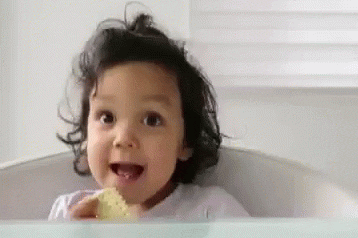